In [1]:
%pip install rdkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 13.2 MB/s eta 0:00:00


In [4]:
pip install pandas numpy scikit-learn matplotlib torch rdkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 848.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

[18:18:18] SMILES Parse Error: syntax error while parsing: Cc1cc(ccc1[N+](=O)[Or])C(=O)NCCc2c([nH]c3c2cccc3)C
[18:18:18] SMILES Parse Error: check for mistakes around position 21:
[18:18:18] Cc1cc(ccc1[N+](=O)[Or])C(=O)NCCc2c([nH]c3
[18:18:18] ~~~~~~~~~~~~~~~~~~~~^
[18:18:18] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(ccc1[N+](=O)[Or])C(=O)NCCc2c([nH]c3c2cccc3)C' for input: 'Cc1cc(ccc1[N+](=O)[Or])C(=O)NCCc2c([nH]c3c2cccc3)C'
[18:18:18] SMILES Parse Error: syntax error while parsing: Cc1c(cccc1OCc2ccccc2)[N+](=O)[Or]
[18:18:18] SMILES Parse Error: check for mistakes around position 32:
[18:18:18] Cc2ccccc2)[N+](=O)[Or]
[18:18:18] ~~~~~~~~~~~~~~~~~~~~^
[18:18:18] SMILES Parse Error: Failed parsing SMILES 'Cc1c(cccc1OCc2ccccc2)[N+](=O)[Or]' for input: 'Cc1c(cccc1OCc2ccccc2)[N+](=O)[Or]'
[18:18:18] SMILES Parse Error: syntax error while parsing: CC1(OC(=O)C(=Cc2ccc(s2)[N+](=O)[Or])C(=O)O1)C
[18:18:18] SMILES Parse Error: check for mistakes around position 34:
[18:18:18] Cc2ccc(s2)[N

PGM Model — R²: 0.60, MSE: 0.57, Accuracy: 0.54


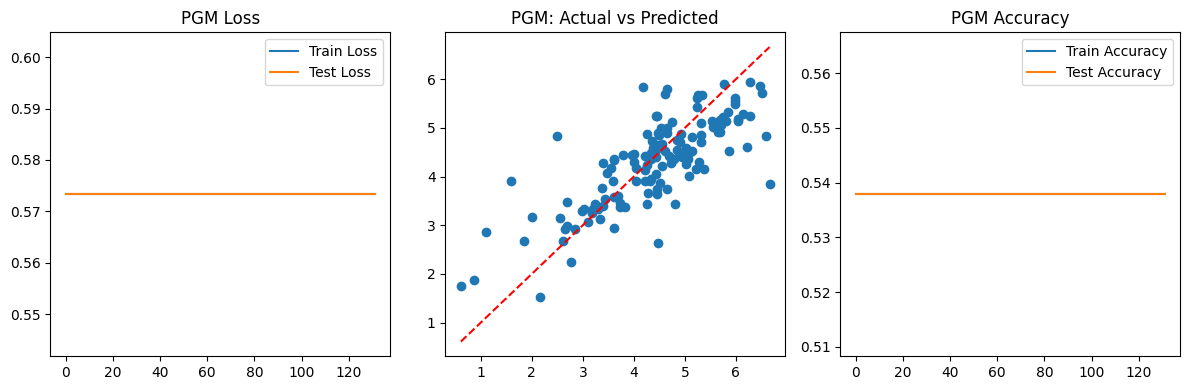

GNN Model — R²: 0.63, MSE: 0.52, Accuracy: 0.53


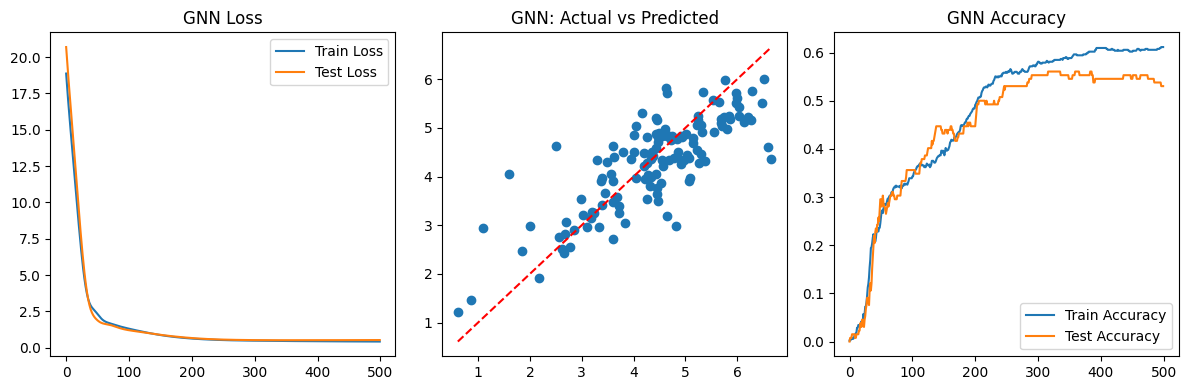

PGM+GNN Model — R²: 0.66, MSE: 0.48, Accuracy: 0.58


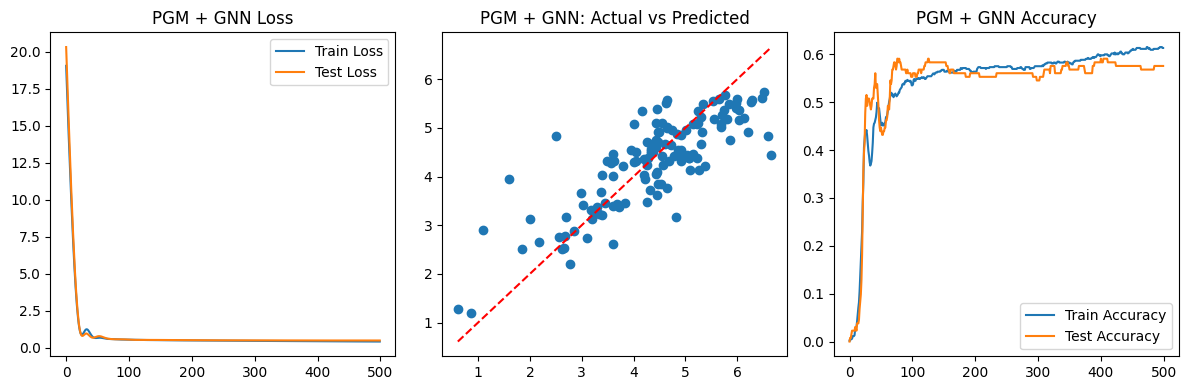

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from rdkit import Chem
from rdkit.Chem import Descriptors

# Load dataset
data = pd.read_csv("logP_experimental_dataset.csv")

# Convert logP to float
data['logP'] = pd.to_numeric(data['logP'], errors='coerce')

# Compute descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [np.nan] * 6
    return [
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.MolLogP(mol)
    ]

descriptor_list = [compute_descriptors(s) for s in data['SMILES']]
X = np.array(descriptor_list)

# Filter invalid rows
data['valid'] = ~np.isnan(X).any(axis=1)
filtered_data = data[data['valid'] & data['logP'].notnull()]
X = X[filtered_data.index]
y = filtered_data['logP'].astype(float).values

# Normalize and split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Accuracy threshold
accuracy_threshold = 0.5

# Define plot function
def plot_results(model_name, y_test, preds, train_losses, test_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title(f"{model_name} Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.scatter(y_test, preds)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.title(f"{model_name}: Actual vs Predicted")

    plt.subplot(1, 3, 3)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Step 1: PGM Model
pgm_model = BayesianRidge()
pgm_model.fit(X_train, y_train)
pgm_preds = pgm_model.predict(X_test)
pgm_r2 = r2_score(y_test, pgm_preds)
pgm_mse = mean_squared_error(y_test, pgm_preds)
pgm_accuracy = np.mean(np.abs(pgm_preds - y_test) < accuracy_threshold)
print(f"PGM Model — R²: {pgm_r2:.2f}, MSE: {pgm_mse:.2f}, Accuracy: {pgm_accuracy:.2f}")
plot_results("PGM", y_test, pgm_preds, [pgm_mse]*len(y_test), [pgm_mse]*len(y_test), [pgm_accuracy]*len(y_test), [pgm_accuracy]*len(y_test))

# Step 2: GNN Model (PyTorch MLP)
class GNN(nn.Module):
    def __init__(self, input_dim):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

device = torch.device("cpu")
X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_t = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32, device=device).view(-1, 1)

gnn_model = GNN(input_dim=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 500
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    gnn_model.train()
    optimizer.zero_grad()
    preds_train = gnn_model(X_train_t)
    loss = criterion(preds_train, y_train_t)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    train_acc = np.mean(np.abs(preds_train.detach().cpu().numpy().flatten() - y_train) < accuracy_threshold)
    train_accuracies.append(train_acc)

    gnn_model.eval()
    with torch.no_grad():
        preds_test = gnn_model(X_test_t)
        test_loss = criterion(preds_test, y_test_t)
        test_acc = np.mean(np.abs(preds_test.cpu().numpy().flatten() - y_test) < accuracy_threshold)
        test_losses.append(test_loss.item())
        test_accuracies.append(test_acc)

gnn_preds = gnn_model(X_test_t).detach().cpu().numpy().flatten()
gnn_r2 = r2_score(y_test, gnn_preds)
gnn_mse = mean_squared_error(y_test, gnn_preds)
gnn_accuracy = np.mean(np.abs(gnn_preds - y_test) < accuracy_threshold)
print(f"GNN Model — R²: {gnn_r2:.2f}, MSE: {gnn_mse:.2f}, Accuracy: {gnn_accuracy:.2f}")
plot_results("GNN", y_test, gnn_preds, train_losses, test_losses, train_accuracies, test_accuracies)

# Step 3: Combined Model (PGM + GNN)
pgm_preds_train = pgm_model.predict(X_train)
pgm_preds_test = pgm_model.predict(X_test)
X_train_combined = np.column_stack([X_train, pgm_preds_train])
X_test_combined = np.column_stack([X_test, pgm_preds_test])

X_train_combined_t = torch.tensor(X_train_combined, dtype=torch.float32, device=device)
X_test_combined_t = torch.tensor(X_test_combined, dtype=torch.float32, device=device)

gnn_combined_model = GNN(input_dim=X_train_combined.shape[1]).to(device)
optimizer = torch.optim.Adam(gnn_combined_model.parameters(), lr=0.001)

combined_train_losses, combined_test_losses = [], []
combined_train_accuracies, combined_test_accuracies = [], []

for epoch in range(epochs):
    gnn_combined_model.train()
    optimizer.zero_grad()
    preds_train = gnn_combined_model(X_train_combined_t)
    loss = criterion(preds_train, y_train_t)
    loss.backward()
    optimizer.step()

    combined_train_losses.append(loss.item())
    train_acc = np.mean(np.abs(preds_train.detach().cpu().numpy().flatten() - y_train) < accuracy_threshold)
    combined_train_accuracies.append(train_acc)

    gnn_combined_model.eval()
    with torch.no_grad():
        preds_test = gnn_combined_model(X_test_combined_t)
        test_loss = criterion(preds_test, y_test_t)
        test_acc = np.mean(np.abs(preds_test.cpu().numpy().flatten() - y_test) < accuracy_threshold)
        combined_test_losses.append(test_loss.item())
        combined_test_accuracies.append(test_acc)

gnn_combined_preds = gnn_combined_model(X_test_combined_t).detach().cpu().numpy().flatten()
gnn_combined_r2 = r2_score(y_test, gnn_combined_preds)
gnn_combined_mse = mean_squared_error(y_test, gnn_combined_preds)
gnn_combined_accuracy = np.mean(np.abs(gnn_combined_preds - y_test) < accuracy_threshold)
print(f"PGM+GNN Model — R²: {gnn_combined_r2:.2f}, MSE: {gnn_combined_mse:.2f}, Accuracy: {gnn_combined_accuracy:.2f}")
plot_results("PGM + GNN", y_test, gnn_combined_preds, combined_train_losses, combined_test_losses, combined_train_accuracies, combined_test_accuracies)
